# 5. Single Output Model
---

In this notebook, we implement a model with a single output with multiple class.

## Import Libraries

In [1]:
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import time
from os import path
import sys
sys.path.append("../src")
from utils import destination, show_images

Using TensorFlow backend.


## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [2]:
DATA_LIST = "../HARRISON/2.4_balanced_data_list.txt"
TAG_LIST = "../HARRISON/2.4_balanced_tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None,skip_blank_lines=False).fillna("")
hashtag["labels"] = hashtag["labels"].apply(lambda x: x.split(" "))

print(filename.shape,hashtag.shape)

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target = shuffle(target, random_state=42)
target.head(5)

(55371, 1) (55371, 1)


,filename,labels
20427,fashion_image_1126.jpg,"[dress, fashion, fashionable, fashionaddict, f..."
48237,family_image_4548.jpg,"[explore, family, fun, happy, holiday, instatr..."
36130,girls_image_1424.jpg,"[girl, girly, instagirl, girls, ]"
7182,friday_image_723.jpg,"[bday, birthday, birthdaycake, blonde, cake, c..."
12725,nike_image_2023.jpg,"[adidas, airmax, justdoit, kick, nike, nikeair..."


In [3]:
# Read hashtags
with open("../model/hashtags.txt") as f:
    # Read tag_list
    hashtags = f.read().split('\n')
hashtags = hashtags[:-1]

num_images = target.shape[0]
num_hashtags = len(hashtags)

print(f"Number of images: {num_images}")
print(f"Number of hashtags: {num_hashtags}")

Number of images: 55371
Number of hashtags: 997


## Prepare Images

In [4]:
IMAGE_DIR = "../HARRISON/images"

datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

# Use these values to split data into train, val, and test
train_idx = int(num_images * .70)
val_idx = int(num_images * .90)

train_generator = datagen.flow_from_dataframe(
    dataframe=target[:train_idx],
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="labels",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    classes=hashtags,
    target_size=(100,100))

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=target[train_idx:val_idx],
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="labels",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    classes=hashtags,
    target_size=(100,100))

test_generator = test_datagen.flow_from_dataframe(
    dataframe=target[val_idx:],
    directory=IMAGE_DIR,
    x_col="filename",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(100,100))

Found 38759 validated image filenames belonging to 997 classes.
Found 11074 validated image filenames belonging to 997 classes.
Found 5538 validated image filenames.


## Build a Model
### 1. Multiple Output Nodes

In [5]:
# Define model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_hashtags, activation='sigmoid'))

# Compile model
model.compile(
    optimizers.rmsprop(lr=0.0001, decay=1e-6),
    loss="binary_crossentropy",
    metrics=["accuracy"])

# Show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 64)       

## Fitting the Model

In [6]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

start_time = time.time()
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=4,
    verbose=2)
print(f"--- {time.time() - start_time} seconds ---")

Epoch 1/4
 - 1689s - loss: 0.0638 - accuracy: 0.9846 - val_loss: 0.0514 - val_accuracy: 0.9895
Epoch 2/4
 - 1675s - loss: 0.0487 - accuracy: 0.9895 - val_loss: 0.0514 - val_accuracy: 0.9895
Epoch 3/4
 - 1668s - loss: 0.0478 - accuracy: 0.9896 - val_loss: 0.0530 - val_accuracy: 0.9895
Epoch 4/4
 - 1736s - loss: 0.0473 - accuracy: 0.9896 - val_loss: 0.0434 - val_accuracy: 0.9895
--- 6768.787361621857 seconds ---


In [7]:
import os

# Save model for future use
root = os.path.join("..", "model")
model.save(destination(root, "keras_model_5_mlsol"))

In [8]:
# Load model
model = load_model("../model/1117025803_keras_model_5_mlsol")

OSError: Unable to open file (unable to open file: name = '../model/1117025803_keras_model_5_mlsol', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Show Learning History

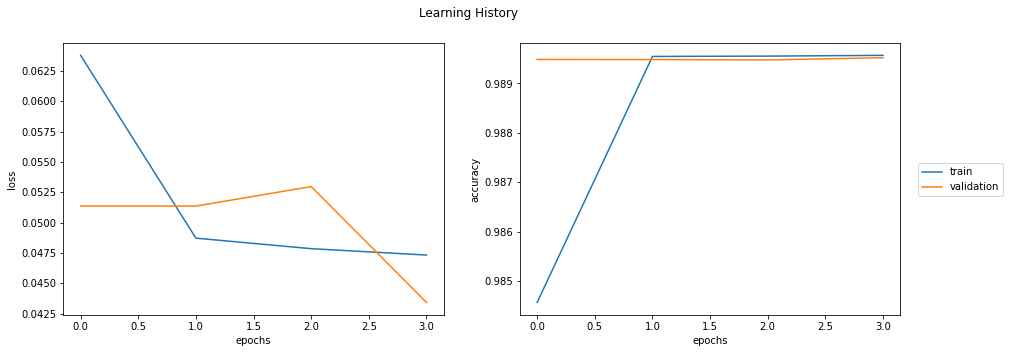

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
metric = ["loss", "accuracy"]

for idx in range(len(metric)):
    axs[idx].plot(history.history[metric[idx]], label="train")
    axs[idx].plot(history.history[f"val_{metric[idx]}"], label="validation")
    axs[idx].set(ylabel=metric[idx], xlabel="epochs")

fig.suptitle("Learning History")
plt.legend(loc="center right", bbox_to_anchor=(0,0,1,1),bbox_transform=plt.gcf().transFigure)

plt.show()

## Prediction

In [10]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

173/173 [==============================] - 153s 887ms/step


In [11]:
def get_conf(row: list) -> dict:
    # Get hashtags with confidence
    keys = np.array(hashtags)[np.argwhere(row>0).flatten()]
    values = row[np.where(row>0)]
    
    # Sort the result 
    idx = values.argsort()[::-1]
    values = values[idx]
    keys = keys[idx]
    dict(zip(keys, values))

    return dict(zip(keys, values))

In [12]:
# Zscore normalization
normalized = (pred - pred.mean())/pred.std()
abv3std = np.where(normalized>3, normalized, 0)

# Get lists of hashtags
y_pred = pd.concat([
    pd.Series(test_generator.filenames, name="filename"),
    pd.Series([get_conf(row) for row in abv3std], name="y_pred")],
    axis=1)

results = target[["filename", "labels"]][val_idx:]
results.rename(columns={"labels": 'y_true'}, inplace=True)
results.index = y_pred.index

s = pd.Series([list(row.keys()) for row in y_pred.y_pred if type(row) == dict], name="y_pred")
results["y_pred"] = s

results.loc[2,['filename']]

filename    dog_image_1015.jpg
Name: 2, dtype: object

## Prediction Results
Only top 15 (in terms of confidence) hashtags are shown with the pictures.

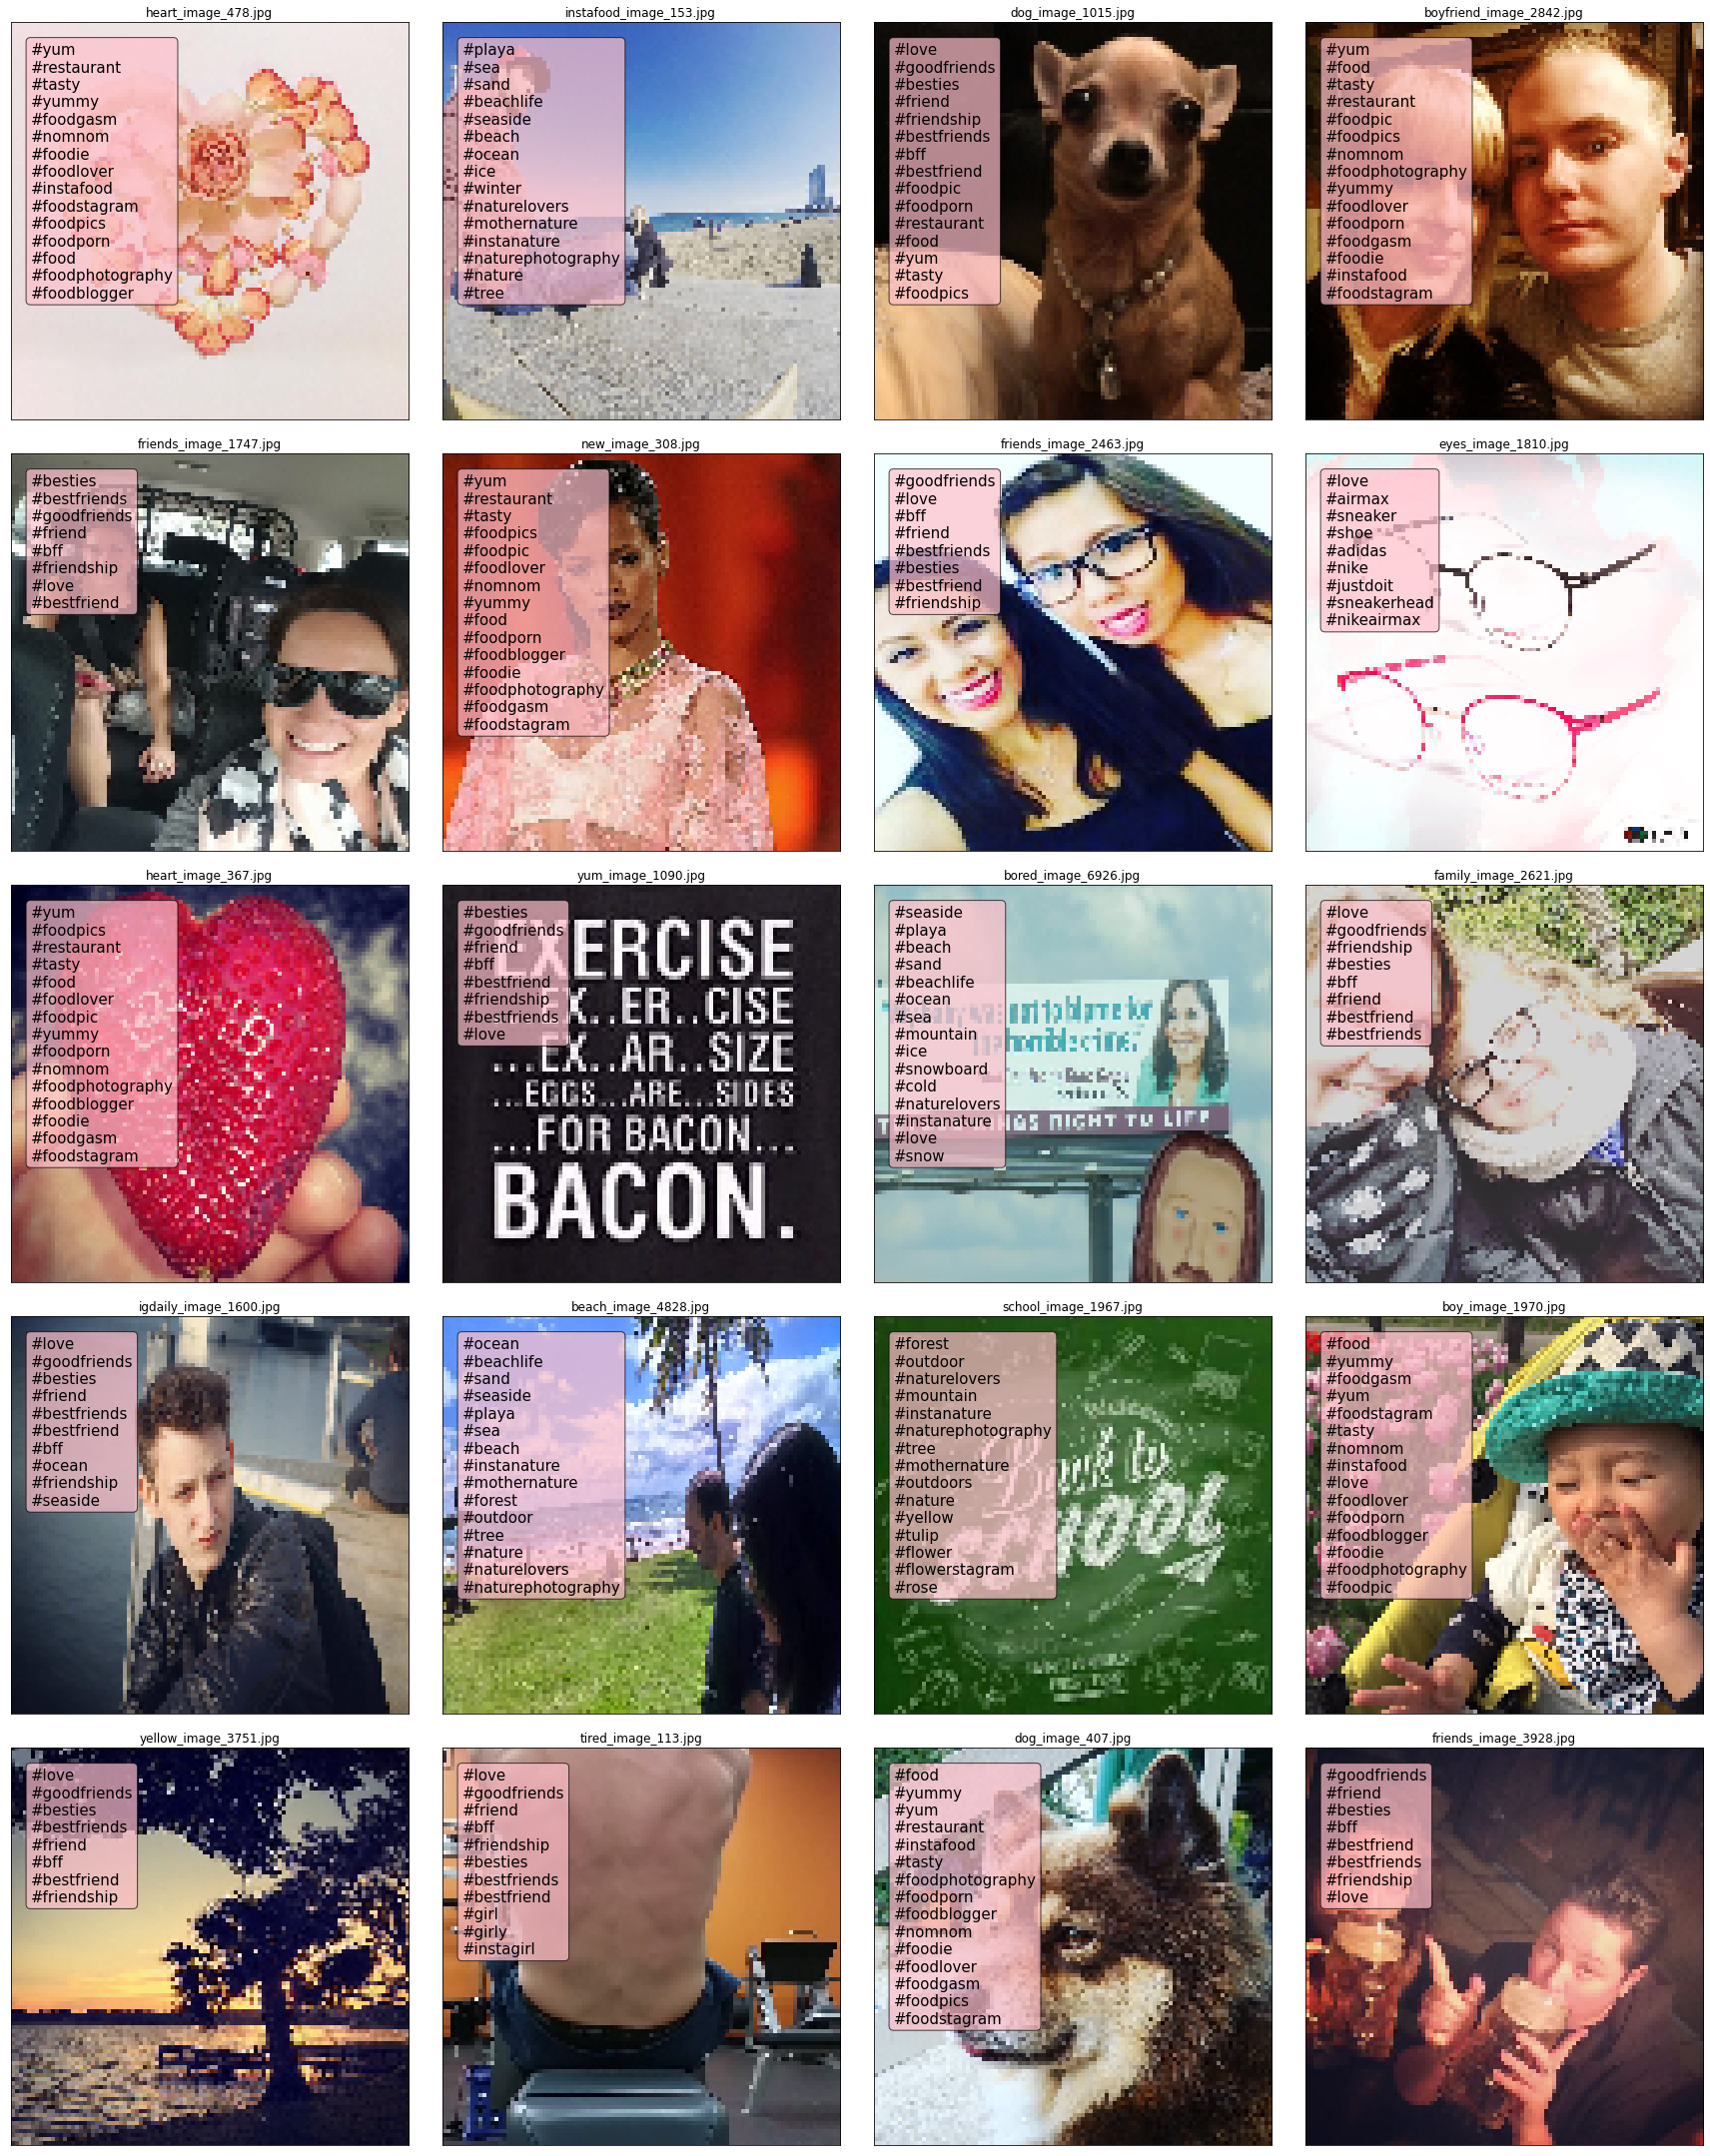

In [13]:
def get_top_tags(tag_list):
    if type(tag_list) != list:
        return tag_list
    else:
        return tag_list[:15]


top10 = results["y_pred"].apply(get_top_tags)
show_images(test_generator, data_list=results.filename, tag_list=top10, categorical=False)